## How and why does Batch Normalization Work? 
In this experiment, we will compare the performance of a fully-connected deep neural network on the MNIST dataset with and without batch normalization. Additionally, we will dive into the details of how and why batch normalization works.

### Let's start by loading the MNIST dataset

MNIST consists of 70,000 images of handwritten digits, where each image is a 28x28 grayscale pixel grid. The dataset is split into 60,000 training examples and 10,000 test examples, with labels ranging from 0 to 9. Each image in MNIST represents a single digit written by different individuals, providing variety in handwriting styles. The pixel values range from 0 (black) to 255 (white).

In [1]:
import tensorflow_datasets as tfds
import jax
import jax.numpy as jnp

rng = jax.random.PRNGKey(42)

train_tf, test_tf = tfds.load('mnist', split=['train', 'test'], batch_size=-1, as_supervised=True)

train_images, train_labels = train_tf[0], train_tf[1]
train_images = jnp.float32(train_images)
train_images = train_images.reshape((train_images.shape[0], -1))
train_labels = jnp.float32(train_labels)

test_images, test_labels = test_tf[0], test_tf[1]
test_images = jnp.float32(test_images)
test_images = test_images.reshape((test_images.shape[0], -1))
test_labels = jnp.float32(test_labels)

print(f"Training Set Size {train_images.shape[0]}")
print(f"Test Set Size {test_images.shape[0]}")

Training Set Size 60000
Test Set Size 10000


Let's look at a few training examples:

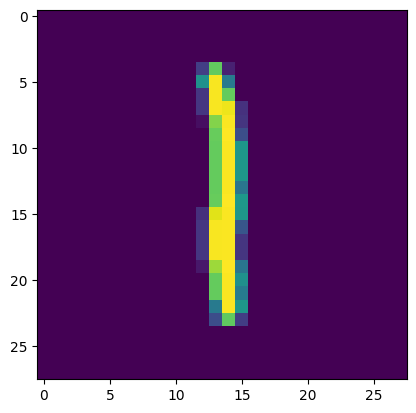

In [2]:
import matplotlib.pyplot as plt

rng, sub_rng = jax.random.split(rng)
i = jax.random.randint(sub_rng, (1,), 0, train_images.shape[0])
ex = train_images[i,:].reshape((28,28,1))
plt.imshow(ex)
plt.show()

What does our dataset look like? 
It looks like the feature values are a bimodal distribution, with a big peak close to 0 and a small one close to 255.

Mean: 33.31842041015625, Variance: 78.5675048828125


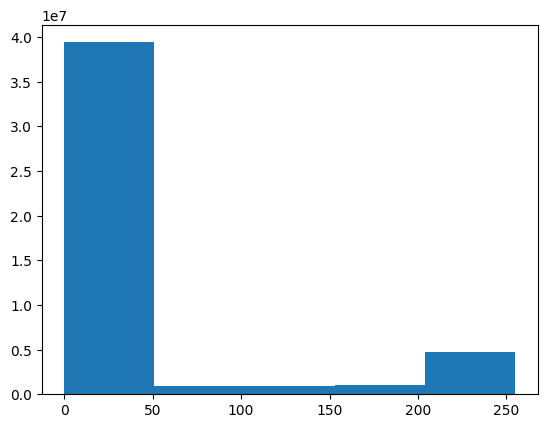

In [3]:
pixels = train_images.flatten()
print(f"Mean: {pixels.mean()}, Variance: {pixels.std()}")
plt.hist(pixels, bins=5)
plt.show()

Let's normalize our dataset

33.318417 78.56721
2.8215535
33.318417 78.56721
2.8215535


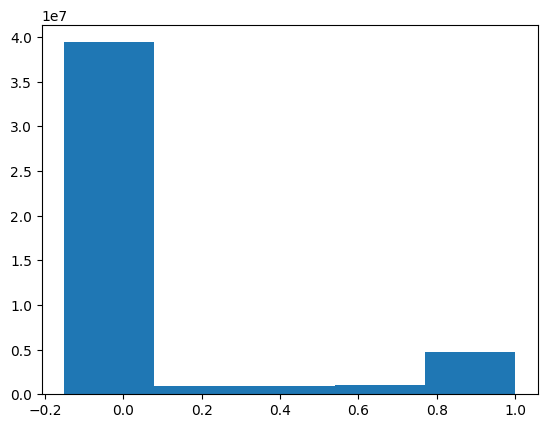

In [4]:
train_mean = train_images.mean()
train_std = train_images.std()
print(train_mean, train_std)
train_images = (train_images - train_mean)/train_std
train_max = train_images.max()
print(train_max)
train_images = train_images/train_max

test_mean = test_images.mean()
test_std = test_images.std()
print(train_mean, train_std)
test_images = (test_images - test_mean)/test_std
test_max = test_images.max()
print(train_max)
test_images = test_images/test_max


pixels = train_images.flatten()
plt.hist(pixels, bins=5)
plt.show()

### Now, we're going to train a fully-connected network to classify the digits

Number of baseline parameters: 109386
Baseline P/S ratio: 1.8231
Number of candidate parameters: 109770
Candidate P/S ratio: 1.8295


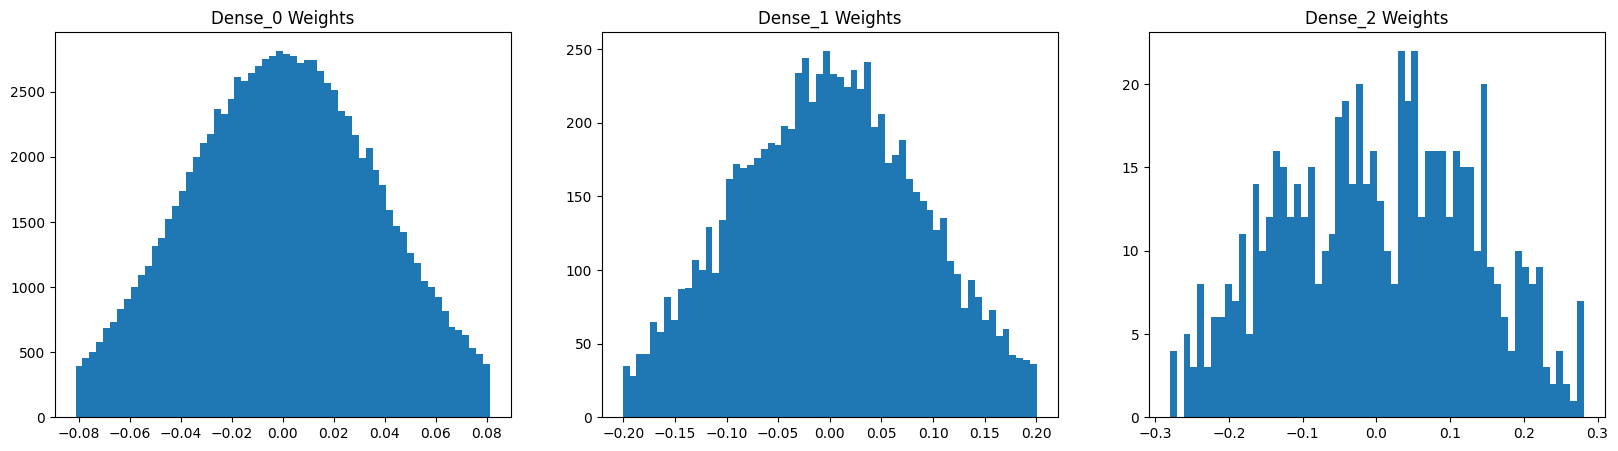

In [5]:
from typing import Dict, Any

from functools import reduce
import operator

from time import sleep

from flax import linen as nn
from flax.training import train_state
import optax

rng = jax.random.PRNGKey(42)
from matplotlib.animation import FuncAnimation

class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        outputs = {}
        x = nn.Dense(128)(x)             
        outputs['Dense_0'] = x
        x = nn.relu(x)
        outputs['Relu_0'] = x

        x = nn.Dense(64)(x)              
        outputs['Dense_1'] = x
        x = nn.relu(x)
        outputs['Relu_1'] = x

        x = nn.Dense(10)(x)              
        outputs['Dense_2'] = x
        return x, outputs

class MLPBatchNorm(nn.Module):
    @nn.compact
    def __call__(self, x, train: bool = True):
        outputs = {}
        x = nn.Dense(128)(x)             
        outputs['Dense_0'] = x
        x = nn.BatchNorm(use_running_average=not train)(x)  
        outputs['BatchNorm_0'] = x
        x = nn.relu(x)
        outputs['Relu_0'] = x

        x = nn.Dense(64)(x)              
        outputs['Dense_1'] = x
        x = nn.BatchNorm(use_running_average=not train)(x)  
        outputs['BatchNorm_1'] = x
        x = nn.relu(x)
        outputs['Relu_1'] = x

        x = nn.Dense(10)(x)              
        outputs['Dense_2'] = x
        return x, outputs

# Initialize the baseline model
baseline_model = MLP()
dummy_input = jnp.ones((32, 28*28))
baseline_variables = baseline_model.init(rng, dummy_input)
baseline_params = baseline_variables['params']

# Initialize the candidate model
candidate_model = MLPBatchNorm()
dummy_input = jnp.ones((32, 28*28))
candidate_variables = candidate_model.init(rng, dummy_input, train=True)
candidate_params = candidate_variables['params']
candidate_batch_stats = candidate_variables['batch_stats']


# Count the # of baseline model parameters
def count_params(params):
    num_params = 0
    for layer in params:
        for key in params[layer]:
            shape = params[layer][key].shape
            num_params += reduce(operator.mul, shape)
    return num_params

num_baseline_params = count_params(baseline_params)
num_candidate_params = count_params(candidate_params)

print(f"Number of baseline parameters: {num_baseline_params}")
print(f"Baseline P/S ratio: {num_baseline_params/train_images.shape[0]:0.4f}")
print(f"Number of candidate parameters: {num_candidate_params}")
print(f"Candidate P/S ratio: {num_candidate_params/train_images.shape[0]:0.4f}")

# Lets plot the initial baseline model weight distributions
fig, axs = plt.subplots(1, 3, figsize=[20, 5])

dense0_w = baseline_params['Dense_0']['kernel'].flatten()
dense1_w = baseline_params['Dense_1']['kernel'].flatten()
dense2_w = baseline_params['Dense_2']['kernel'].flatten()

titles = ['Dense_0 Weights', 'Dense_1 Weights', 'Dense_2 Weights']

for ax, title in zip(axs, titles):
    ax.set_title(title)

axs[0].hist(dense0_w, bins=60)
axs[1].hist(dense1_w, bins=60)
axs[2].hist(dense2_w, bins=60)


plt.show()

In [6]:
import optax
from flax.training import train_state

rng = jax.random.PRNGKey(43)
LR = 0.001

# Create a train state
tx = optax.adam(learning_rate=LR)
baseline_ts = train_state.TrainState.create(apply_fn=baseline_model.apply, params=baseline_params, tx=tx)

def compute_loss(params, apply_fn, images, labels):
    variables = {'params': params}
    logits, updated_variables = apply_fn(variables, images)
    one_hot_labels = jax.nn.one_hot(labels, 10)
    loss = optax.softmax_cross_entropy(logits, one_hot_labels).mean()
    return loss

@jax.jit
def train_step(state, images, labels):
    def loss_fn(params):
        return compute_loss(params, state.apply_fn, images, labels)
    grads = jax.grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return grads, state 

@jax.jit
def eval_step(state, images, labels):
    variables = {'params': state.params}
    logits, outputs = state.apply_fn(variables, images)
    predictions = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(predictions == labels)
    return accuracy, outputs


def train_and_evaluate(rng, model, ts, train_images, train_labels, test_images, test_labels):

    num_epochs = 10
    batch_size = 32
    num_train = train_images.shape[0]

    train_accuracy, outputs = eval_step(ts, train_images, train_labels)
    test_accuracy, _ = eval_step(ts, test_images, test_labels)
    print(f'Epoch 0, Train Accuracy: {train_accuracy:0.4f}, Test Accuracy: {test_accuracy:.4f}')
    params_history = [ts.params]
    outputs_history = [outputs]
    grads_history = []

    for epoch in range(num_epochs):

        rng, sub_rng = jax.random.split(rng)
        permutation = jax.random.permutation(sub_rng, num_train)
        train_images = train_images[permutation]
        train_labels = train_labels[permutation]
        
        for i in range(0, num_train, batch_size):
            batch_images = train_images[i:i + batch_size]
            batch_labels = train_labels[i:i + batch_size]
            grads, ts = train_step(ts, batch_images, batch_labels)
            if epoch == 0: 
                grads_history.append(grads)
        train_accuracy, outputs = eval_step(ts, train_images, train_labels)
        test_accuracy, _ = eval_step(ts, test_images, test_labels)
        print(f'Epoch {epoch + 1}, Train Accuracy: {train_accuracy:0.4f}, Test Accuracy: {test_accuracy:.4f}')
        params_history.append(ts.params)
        outputs_history.append(outputs)

        #if train_accuracy > 0.999:
        #    break

    return grads_history, params_history, outputs_history

baseline_grads_history, baseline_params_history, baseline_outputs_history = train_and_evaluate(rng, baseline_model, baseline_ts, train_images, train_labels, test_images, test_labels)


Epoch 0, Train Accuracy: 0.1189, Test Accuracy: 0.1168
Epoch 1, Train Accuracy: 0.9674, Test Accuracy: 0.9643
Epoch 2, Train Accuracy: 0.9797, Test Accuracy: 0.9706
Epoch 3, Train Accuracy: 0.9668, Test Accuracy: 0.9563
Epoch 4, Train Accuracy: 0.9867, Test Accuracy: 0.9745
Epoch 5, Train Accuracy: 0.9881, Test Accuracy: 0.9745
Epoch 6, Train Accuracy: 0.9889, Test Accuracy: 0.9722
Epoch 7, Train Accuracy: 0.9884, Test Accuracy: 0.9722
Epoch 8, Train Accuracy: 0.9918, Test Accuracy: 0.9742
Epoch 9, Train Accuracy: 0.9947, Test Accuracy: 0.9785
Epoch 10, Train Accuracy: 0.9945, Test Accuracy: 0.9755


In [7]:
import optax
from flax.training import train_state

rng = jax.random.PRNGKey(43)
LR = 0.001

# Create a train state
tx = optax.adam(learning_rate=LR)
candidate_ts = train_state.TrainState.create(apply_fn=candidate_model.apply, params=candidate_params, tx=tx)

def compute_loss(params, batch_stats, apply_fn, images, labels, train):
    variables = {'params': params, 'batch_stats': batch_stats}
    outputs, updated_variables = apply_fn(variables, images, train=train, mutable=['batch_stats'])
    logits, _ = outputs
    one_hot_labels = jax.nn.one_hot(labels, 10)
    loss = optax.softmax_cross_entropy(logits, one_hot_labels).mean()
    return loss, updated_variables['batch_stats']

@jax.jit
def train_step(state, batch_stats, images, labels):
    def loss_fn(params):
        return compute_loss(params, batch_stats, state.apply_fn, images, labels, train=True)
    grads, updated_batch_stats = jax.grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    return grads, state, updated_batch_stats

@jax.jit
def eval_step(state, batch_stats, images, labels):
    variables = {'params': state.params, 'batch_stats': batch_stats}
    logits, outputs = state.apply_fn(variables, images, train=False)
    predictions = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(predictions == labels)
    return accuracy, outputs


def train_and_evaluate(rng, model, ts, batch_stats, train_images, train_labels, test_images, test_labels):

    num_epochs = 10
    batch_size = 32
    num_train = train_images.shape[0]

    train_accuracy, outputs = eval_step(ts, batch_stats, train_images, train_labels)
    test_accuracy, _ = eval_step(ts, batch_stats, test_images, test_labels)
    print(f'Epoch 0, Train Accuracy: {train_accuracy:0.4f}, Test Accuracy: {test_accuracy:.4f}')
    params_history = [ts.params]
    batch_stats_history = [batch_stats]
    outputs_history = [outputs]
    grads_history = []

    for epoch in range(num_epochs):

        rng, sub_rng = jax.random.split(rng)
        permutation = jax.random.permutation(sub_rng, num_train)
        train_images = train_images[permutation]
        train_labels = train_labels[permutation]
        
        for i in range(0, num_train, batch_size):
            batch_images = train_images[i:i + batch_size]
            batch_labels = train_labels[i:i + batch_size]
            grads, ts, batch_stats = train_step(ts, batch_stats, batch_images, batch_labels)
            if epoch == 0:
                grads_history.append(grads)

        train_accuracy, outputs = eval_step(ts, batch_stats, train_images, train_labels)
        test_accuracy, _ = eval_step(ts, batch_stats, test_images, test_labels)
        print(f'Epoch {epoch + 1}, Train Accuracy: {train_accuracy:0.4f}, Test Accuracy: {test_accuracy:.4f}')
        params_history.append(ts.params)
        batch_stats_history.append(batch_stats)
        outputs_history.append(outputs)

        #if train_accuracy > 0.999:
        #    break

    return grads_history, params_history, batch_stats_history, outputs_history

candidate_grads_history, candidate_params_history, candidate_batch_stats_history, candidate_outputs_history = train_and_evaluate(rng, candidate_model, candidate_ts, candidate_batch_stats, train_images, train_labels, test_images, test_labels)


Epoch 0, Train Accuracy: 0.1189, Test Accuracy: 0.1168
Epoch 1, Train Accuracy: 0.9711, Test Accuracy: 0.9643
Epoch 2, Train Accuracy: 0.9833, Test Accuracy: 0.9733
Epoch 3, Train Accuracy: 0.9873, Test Accuracy: 0.9764
Epoch 4, Train Accuracy: 0.9898, Test Accuracy: 0.9769
Epoch 5, Train Accuracy: 0.9923, Test Accuracy: 0.9790
Epoch 6, Train Accuracy: 0.9935, Test Accuracy: 0.9798
Epoch 7, Train Accuracy: 0.9939, Test Accuracy: 0.9789
Epoch 8, Train Accuracy: 0.9950, Test Accuracy: 0.9800
Epoch 9, Train Accuracy: 0.9960, Test Accuracy: 0.9818
Epoch 10, Train Accuracy: 0.9970, Test Accuracy: 0.9812


Let's plot the histograms for the activations for each layer

(60000,)
(60000,)
(26453,)


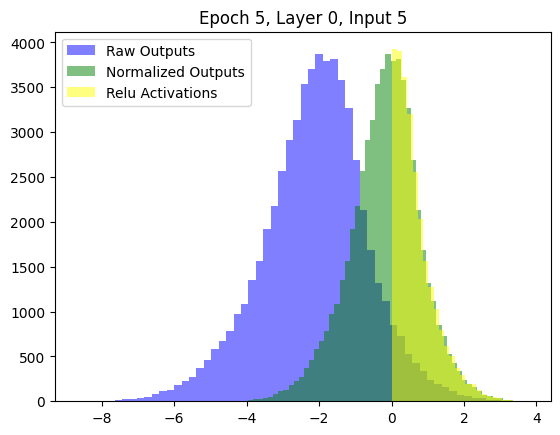

In [11]:
epoch = 5
input_idx = 5
layer_id = 0
bins = 60

raw_outputs = candidate_outputs_history[epoch][f"Dense_{layer_id}"][:, input_idx].flatten()
plt.hist(raw_outputs, bins=bins, color="blue", alpha=0.5)
norm_outputs = candidate_outputs_history[epoch][f"BatchNorm_{layer_id}"][:, input_idx].flatten()
#norm_outputs = norm_outputs[norm_outputs >= 0]
print(norm_outputs.shape)
plt.hist(norm_outputs, bins=bins, color="green", alpha=0.5)
act_outputs = candidate_outputs_history[epoch][f"Relu_{layer_id}"][:, input_idx].flatten()
print(act_outputs.shape)
act_outputs = act_outputs[act_outputs > 0]
print(act_outputs.shape)
plt.hist(act_outputs, bins=int(bins*act_outputs.shape[0]/norm_outputs.shape[0]), color="yellow", alpha=0.5)
plt.title(f"Epoch {epoch}, Layer {layer_id}, Input {input_idx}")
plt.legend(["Raw Outputs", "Normalized Outputs", "Relu Activations"])
plt.show()

Now let's plot the histograms for the layer weights over time

In [13]:
import functools
import numpy as np
import matplotlib.animation as animation

# Output generated via `matplotlib.animation.Animation.to_jshtml`.
fig, ax = plt.subplots()
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()

LAYER='Dense_0'
PARAM='kernel'

def animate(frame, bar_container):
    # Simulate new data coming in.
    n, _ = np.histogram(frame, 60)
    for count, rect in zip(n, bar_container.patches):
        rect.set_height(count)

    return bar_container.patches

data = baseline_params_history[0][LAYER][PARAM].flatten()
_, _, bar_container = ax.hist(data, bins=60, ec="yellow", fc="green", alpha=0.5)

frames = [ p[LAYER][PARAM].flatten() for p in baseline_params_history ]

anim = functools.partial(animate, bar_container=bar_container)
animation.FuncAnimation(fig, anim, frames, repeat=False, blit=True)

Now let's plot the values of parameters over time

(784, 128)


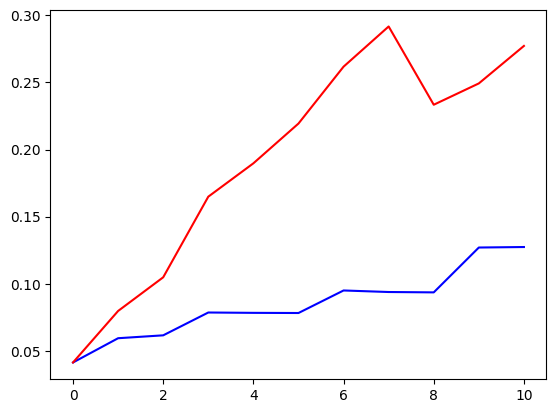

In [ ]:
LAYER='Dense_0'
PARAM='kernel'
param_i = 40
param_j = 27

params_shape = baseline_params[LAYER][PARAM].shape
print(params_shape)

baseline_vals = []
for epoch in range(len(baseline_params_history)):
    val = baseline_params_history[epoch][LAYER][PARAM][param_i, param_j]
    baseline_vals.append(val)
candidate_vals = []
for epoch in range(len(candidate_params_history)):
    val = candidate_params_history[epoch][LAYER][PARAM][param_i, param_j]
    candidate_vals.append(val)

plt.plot(range(len(baseline_params_history)), baseline_vals, color="blue")
plt.plot(range(len(candidate_params_history)), candidate_vals, color="red")
plt.show()


Let's plot the gradients over time

(128, 64)


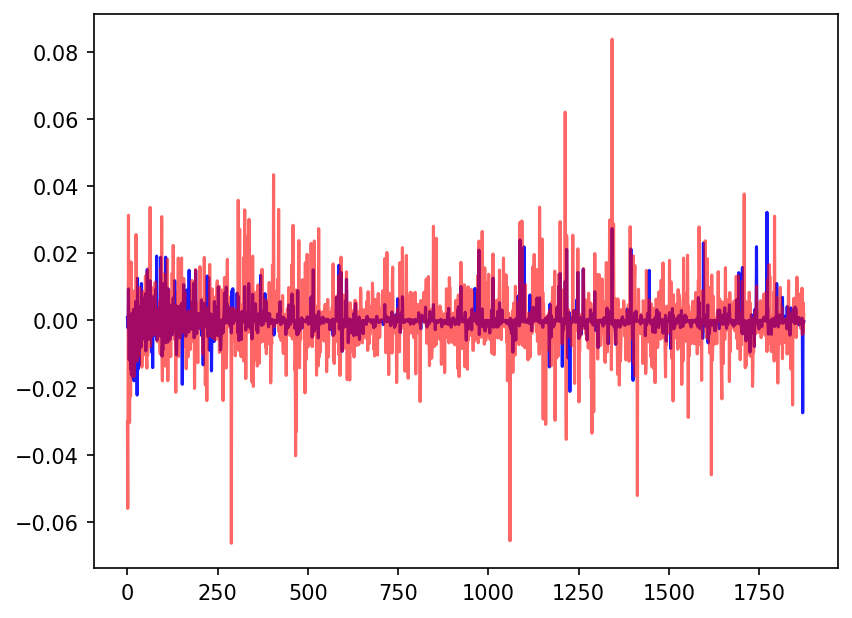

In [15]:
LAYER='Dense_1'
PARAM='kernel'
param_i = 60
param_j = 10 


layer_shape = baseline_params[LAYER][PARAM].shape
print(layer_shape)

baseline_grads = []
baseline_grad_means = []
baseline_grad_stds = []
for epoch in range(len(baseline_grads_history)):
    grads = baseline_grads_history[epoch][LAYER][PARAM]
    baseline_grad_means.append(grads.mean())
    baseline_grad_stds.append(grads.std())
    baseline_grads.append(grads[param_i, param_j])

candidate_grads = []
candidate_grad_means = []
candidate_grad_stds = []
for epoch in range(len(candidate_grads_history)):
    grads = candidate_grads_history[epoch][LAYER][PARAM]
    candidate_grad_means.append(grads.mean())
    candidate_grad_stds.append(grads.std())
    candidate_grads.append(grads[param_i, param_j])

plt.plot(range(len(baseline_grads_history)), baseline_grads, color="blue", alpha=0.9)
plt.plot(range(len(candidate_grads_history)), candidate_grads, color="red", alpha=0.6)
plt.show()

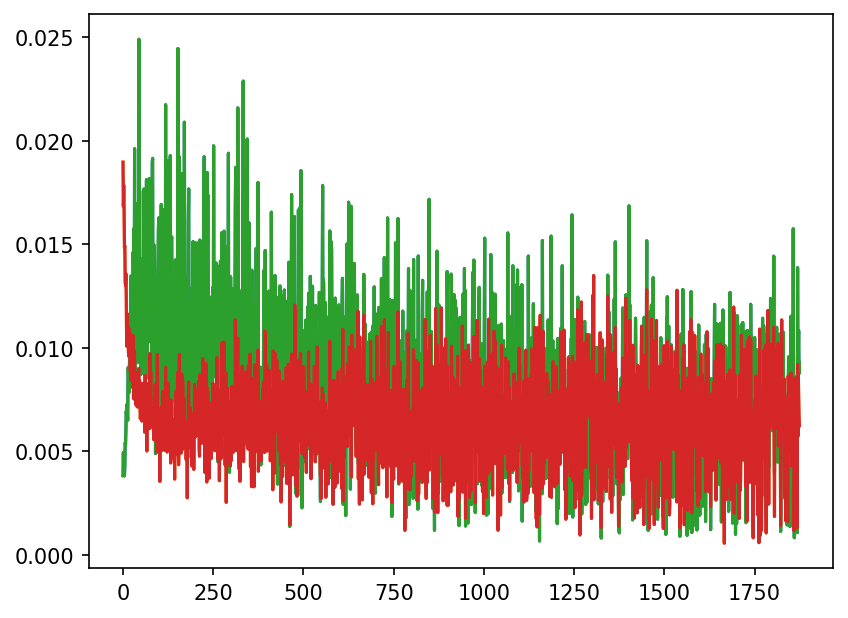

In [17]:
plt.plot(baseline_grad_stds)
plt.plot(candidate_grad_stds)
plt.show()